# OSMNX learning
Maybe an easier method than using Overpy because it natively creates geodataframes

In [1]:
import pandas as pd
import requests
import json
import geopandas as gpd
import contextily as cx
from copy import deepcopy
import geopy.distance
from shapely.geometry import MultiPolygon, Polygon, Point, LineString
import osmnx as ox
import pyproj

import pickle
import webbrowser

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import warnings
# Suppress FutureWarning messages
warnings.simplefilter('ignore', DeprecationWarning)


In [2]:
# Load nation lakes coords   
with open("nation_lakes.json") as f:
    lakes = json.load(f)
print("\nlakes:")
for i,lake in enumerate(lakes):
    print(i,lake["name"])


lakes:
0 Tsayta Lake
1 Indata Lake
2 Tchentlo Lake
3 Chuchi Lake


In [3]:
place = lakes[0]
place_name = place["name"].replace(" ", "-")
print(place)
corners = (place["south"],place["west"],place["north"],place["east"])

desired_tags = {
    'leisure': ['park','nature_reserve'],
    'tourism': ['camp_site'],
    'natural': ['peak', 'mountain_range', 'volcano', 'spring'],
    'highway': ['motorway', 'trunk','primary','secondary','tertiary','unclassified','track','road','path', 'footway'],
    'water':['lake', 'river'],
    'barrier': ['yes']
}

{'name': 'Tsayta Lake', 'north': 55.48292, 'west': -125.65, 'south': 55.41749450097668, 'east': -125.31534497067527, 'lat': 55.45020725048834, 'lon': -125.47967248533763}


In [4]:

gdf = ox.features.features_from_bbox(place["north"], place["south"], place["east"], place["west"], desired_tags)
gdf = gdf.to_crs(epsg=3857) # project to spherical mercator to match tiles
gdf.reset_index(inplace=True)
cols = ['nodes', 'ways','osmid']
gdf.drop(columns=cols, inplace=True)

gdf

,element_type,geometry,tourism,name,leisure,source,highway,surface,attribution,geobase:acquisitionTechnique,lanes,tracktype,bridge,natural,water,boundary,type,wikidata,wikipedia
0,node,POINT (-13954643.065 7449910.188),camp_site,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node,POINT (-13955949.355 7450868.038),camp_site,Kwanila Beach,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node,POINT (-13964918.767 7450925.500),camp_site,Big Island,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node,POINT (-13968879.459 7449976.162),camp_site,Andrew Bay,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node,POINT (-13971662.691 7451464.295),camp_site,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,node,POINT (-13984411.856 7453967.306),camp_site,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,way,"LINESTRING (-13998631.419 7455745.205, -139986...",NaN,Driftwood Forest Service Road,NaN,NaN,tertiary,unpaved,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,way,"LINESTRING (-13989579.407 7454466.128, -139895...",NaN,Fall-Tsayta Forest Service Road,NaN,Geobase_Import_2009,unclassified,unpaved,GeoBase®,GPS,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,way,"LINESTRING (-13986980.131 7454231.325, -139869...",NaN,NaN,NaN,NaN,track,NaN,NaN,NaN,NaN,grade4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,way,"LINESTRING (-13984530.846 7453873.273, -139845...",NaN,Fall-Tsayta Forest Service Road,NaN,Geobase_Import_2009,unclassified,unpaved,GeoBase®,GPS,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [202]:
elements = gdf.to_dict(orient = "records")
elements[0]

C:\Users\Trevor_Kinsey\miniconda3\envs\mapping\lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)


{'element_type': 'node',
 'geometry': <POINT (-13954643.065 7449910.188)>,
 'tourism': 'camp_site',
 'name': nan,
 'leisure': nan,
 'source': nan,
 'highway': nan,
 'surface': nan,
 'attribution': nan,
 'geobase:acquisitionTechnique': nan,
 'lanes': nan,
 'tracktype': nan,
 'bridge': nan,
 'natural': nan,
 'water': nan,
 'boundary': nan,
 'type': nan,
 'wikidata': nan,
 'wikipedia': nan}

# Get background tiles

In [203]:
def lonlat_to_xy(lon: float, lat: float):
    """Converts coordinates from EPSG4326 (lon,lat) to EPSG3857(x,y)"""
    proj = pyproj.Transformer.from_crs(4326, 3857, always_xy=True)
    return proj.transform(lon,lat)

def xy_to_lonlat(x: float,y: float):
    """Converts coordinates from EPSG4326 (lon,lat) to EPSG3857(x,y)"""
    proj = pyproj.Transformer.from_crs(3857, 4326, always_xy=True)
    return proj.transform(x,y)


In [204]:
west,east,south,north = place["west"], place["east"], place["south"], place["north"]
# zoom_level = cx.tile._calculate_zoom(west,south,east,north)    
zoom_level = 13
print(f"calculated zoom_level={zoom_level}")

# # convert to epsg 4326
x_min, y_min = lonlat_to_xy(west, south)
x_max, y_max = lonlat_to_xy(east, north) 
map_bounds = (x_min, x_max, y_min, y_max)

tiles_source="https://tiles.stadiamaps.com/tiles/stamen_toner_lite/{z}/{x}/{y}{r}.png?api_key=87e81a5a-4136-409e-92dd-10c6a1a3cb9d"
img, ext = cx.bounds2raster(west,south, east, north, f"{place_name}.tif", zoom_level, source=tiles_source, ll=True)


calculated zoom_level=13


In [205]:
# gdf

In [206]:
# desired_tags

In [207]:
# relation = relations[1]
# for geom in relation["geometry"].geoms:
#     print(geom.geom_type)

In [208]:
# plt.gcf().get_size_inches()

In [209]:
def get_style(element, styles):
    style = None
    for key,value in element.items():
        if key in styles:
            if value in styles[key]:
                style = styles[key][value]
    return style

In [245]:
def extract_coords(geom):
    """Extracts a list of coordinates ((x,y) tuples) for the geometry"""
    coords = []
    if geom.geom_type == "Polygon":
        coords.append(geom.exterior.xy)
    elif geom.geom_type in ["Point", "LineString"]:
        coords.append(geom.coords.xy)
    elif geom.geom_type == "MultiPolygon":
        polygons = [polygon for polygon in geom.geoms]
        for polygon in polygons:
            coords.append(polygon.exterior.xy)
    return coords


In [246]:
geom = elements[-2]["geometry"]
type(geom)
geom.geom_type

'MultiPolygon'

In [247]:
coords = extract_poly_coords(geom)
len(coords["interior_coords"])

23

In [248]:
polygons = [polygon for polygon in geom.geoms]
polygons

[<POLYGON ((-13957418.962 7443795.571, -13958005.203 7442591.848, -13967457.3...>,
 <POLYGON ((-13925740.997 7396629.742, -13927572.046 7396628.436, -13927571.3...>,
 <POLYGON ((-13896666.683 7405645.788, -13896666.984 7405324.79, -13896669.09...>,
 <POLYGON ((-13878389.403 7394941.062, -13878385.418 7395139.499, -13877800.2...>,
 <POLYGON ((-13852728.836 7397744.326, -13852735.604 7397526.032, -13852743.6...>]

In [249]:
# node_marker_size_inch = 0.1
# node_marker_size = (node_marker_size_inch * 72)
node_marker_size = 6

thick_line_width = 2
med_line_width = 1
thin_line_width = 0.4

styles = {
    "node":{
        "tourism": {
            "camp_site": {"marker": "o", "ms": node_marker_size, "mfc":"none", "mec":"green", "alpha": 0.5},
        },
        "natural": {
            "peak": {"marker": "+", "ms": node_marker_size*0.5, "color":"black"},
            "mountain_range": {"marker": "+", "ms": node_marker_size*0.5, "color":"black"},
            "spring": {"marker": "*", "ms": node_marker_size*0.5, "mfc":"none", "mec":"blue", "alpha": 0.5},
        },
        "barrier": {
            "yes": {"marker": "x", "ms": node_marker_size*0.5, "color":"black", "alpha": 0.75},
        }
    },
    "way":  {
        "water": {
            "lake": {"color":"blue", "linewidth":thin_line_width, "alpha": 0.5},
            "river": {"color":"blue", "linewidth":thin_line_width, "alpha": 0.5},
        },
        'highway': {
            "motorway": {"color":"gray", "linewidth":med_line_width},
            "trunk":  {"color":"gray", "linewidth":med_line_width},
            "primary": {"color":"gray", "linewidth":med_line_width},
            "secondary": {"color":"gray", "linewidth":med_line_width},
            "tertiary": {"color":"gray", "linewidth":med_line_width},
            "unclassified": {"color":"gray", "linewidth":med_line_width},
            "track": {"color":"gray", "linewidth":thin_line_width, "linestyle": "-"},
            "road": {"color":"gray", "linewidth":thin_line_width, "linestyle": "-"},
            "path": {"color":"gray", "linewidth":thin_line_width, "linestyle": "--"},
            "footway": {"color":"gray", "linewidth":thin_line_width, "linestyle": "--"},
        },
        'leisure': {
            "park": {"color":"green", "linewidth":thin_line_width, "linestyle": "--"},
        },
    },
    "relation": {
        'leisure': {
            "nature_reserve": {"color":"green", "linewidth":thin_line_width, "linestyle": "--"},
            "park": {"color":"green", "linewidth":thin_line_width, "linestyle": "--"},
        },
         "water": {
            "lake": {"color":"blue", "linewidth":thin_line_width, "alpha": 0.5},
            "river": {"color":"blue", "linewidth":thin_line_width},
        },
        
    }
}

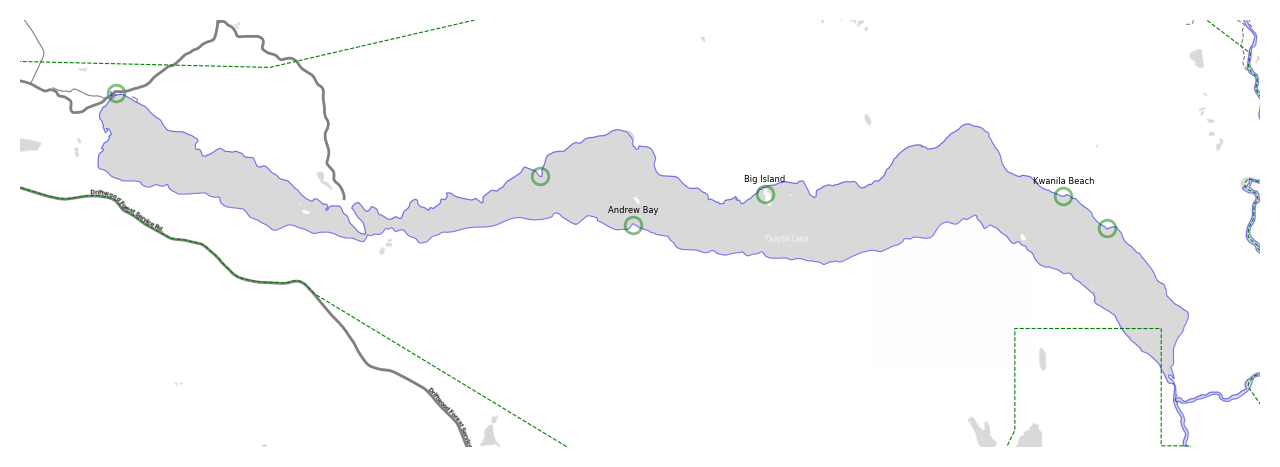

In [250]:
# text_style = dict(horizontalalignment='right', verticalalignment='center',
#                   fontsize=12, fontfamily='monospace')

# make fig with backgound tiles
fig,ax = plt.subplots(1, figsize=(8,8))

fig.set_dpi(200)
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
fig.set_dpi(200)
ax.set_axis_off() # don't display axes with coordinates

cx.add_basemap(ax, source=f"{place_name}.tif", zoom=zoom_level);

for element in elements:
    # get coordinates to plot for this element
    element_type = element["element_type"]
    coords_list = extract_coords(element["geometry"])
    for coords in coords_list:
        ax.plot(coords[0], coords[1], **get_style(element, styles[element_type]))
    if (element_type == "node" and type(element["name"])!=float):
        x,y = coords[0][0], coords[1][0]
        plt.annotate(element["name"], (x,y), size=node_marker_size*0.5, xycoords='data', xytext=(0, node_marker_size*0.75), textcoords='offset points', ha='center')
 


In [198]:
element

{'element_type': 'relation',
 'source': 'DataBC - Recreation Polygon',
 'geometry': <MULTIPOLYGON (((-13860956.081 7398140.275, -13860985.937 7398146.632, -1386...>,
 'name': 'Chuchi Lake North Recreation Site',
 'tourism': nan,
 'leisure': 'park',
 'ref:FFID': 'REC5797',
 'natural': nan,
 'water': nan,
 'highway': nan,
 'boundary': nan,
 'type': 'multipolygon',
 'wikidata': nan,
 'wikipedia': nan}

In [199]:
gdf

C:\Users\Trevor_Kinsey\miniconda3\envs\mapping\lib\site-packages\geopandas\geodataframe.py:1645: DeprecationWarning: Passing a SingleBlockManager to Series is deprecated and will raise in a future version. Use public APIs instead.
  srs = pd.Series(*args, **kwargs)


,element_type,source,geometry,name,tourism,leisure,ref:FFID,natural,water,highway,boundary,type,wikidata,wikipedia
0,node,NaN,POINT (-13860835.789 7398619.178),Chuchi Lake North,camp_site,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node,NaN,POINT (-13842864.805 7394406.744),Chuchi Lake Point A,camp_site,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node,NaN,POINT (-13842963.935 7394088.763),Chuchi Lake Point,camp_site,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node,NaN,POINT (-13855036.066 7397311.957),Rock Bay,camp_site,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node,NaN,POINT (-13853015.261 7397920.470),Point Site,camp_site,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,node,NaN,POINT (-13861900.760 7397783.711),NaN,camp_site,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,node,NaN,POINT (-13865119.185 7392463.278),NaN,camp_site,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,node,NaN,POINT (-13865289.971 7396477.410),NaN,camp_site,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,node,NaN,POINT (-13871889.826 7396576.540),Sarah Point,camp_site,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,node,NaN,POINT (-13877231.013 7395325.174),Jean Marie Creek,camp_site,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
